In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:

def load_data(file_path):
    """
    Load Data: Load the dataset, preprocess it, and return feature matrix X and target vector Y.
    Features (X): 'Rating ?/5', 'Number of Ratings', 'RAM (GB)', 'ROM (GB)', 'Battery (mAh)'
    Target (Y): 'Price in INR'
    """
    print(f"Loading and preprocessing data from: {file_path}")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Ensure the file is in the correct location.")
        return None, None
        
    df_cleaned = df.copy()

    df_cleaned['Price in INR'] = pd.to_numeric(df_cleaned['Price in INR'].astype(str).str.replace('₹', '').str.replace(',', '').str.strip(), errors='coerce')
    df_cleaned['Rating ?/5'] = pd.to_numeric(df_cleaned['Rating ?/5'], errors='coerce')
    df_cleaned['Number of Ratings'] = pd.to_numeric(df_cleaned['Number of Ratings'].astype(str).str.replace(',', '').str.replace('-', '0').str.strip(), errors='coerce')
    df_cleaned['RAM (GB)'] = df_cleaned['RAM'].astype(str).str.extract(r'(\d+)').astype(float)
    df_cleaned['ROM (GB)'] = df_cleaned['ROM/Storage'].astype(str).str.extract(r'(\d+)').astype(float)
    df_cleaned['Battery (mAh)'] = df_cleaned['Battery'].astype(str).str.extract(r'(\d+)').astype(float)

    cols_to_use = ['Rating ?/5', 'Number of Ratings', 'RAM (GB)', 'ROM (GB)', 'Battery (mAh)', 'Price in INR']
    df_cleaned.dropna(subset=cols_to_use, inplace=True)
    
    X = df_cleaned[['Rating ?/5', 'Number of Ratings', 'RAM (GB)', 'ROM (GB)', 'Battery (mAh)']].values
    Y = df_cleaned['Price in INR'].values.reshape(-1, 1) 
    
    print(f"Data cleaned. Total examples: {X.shape[0]}, Total features: {X.shape[1]}")
    return X, Y

def split_data(X, Y, test_size=0.3, random_state=42):
    """Split the data into train (70%) and test (30%) sets."""
    return train_test_split(X, Y, test_size=test_size, random_state=random_state)

def normalize(trainX, testX):
    """Normalize features using StandardScaler."""
    scaler = StandardScaler()
    trainX = scaler.fit_transform(trainX)
    testX = scaler.transform(testX)
    return trainX, testX

def add_bias(X):
    """Add a column of ones to the feature matrix X for the bias term."""
    return np.hstack((np.ones((X.shape[0], 1)), X))

def plot_data(train_costs, test_costs, title, filename):
    """Plot_data: Plot the cost after each epoch for both the train and test set and save to a file."""
    plt.figure(figsize=(10, 6))
    plt.plot(train_costs, label='Train Cost')
    plt.plot(test_costs, label='Test Cost')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Cost Function Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def grad_desc(X, Y, theta, learning_rate, num_epoch, X_test, Y_test, cost_func, h_func):
    """
    Gradient_descent: Computes gradients, updates parameters, and records costs.
    """
    m = len(Y)
    train_costs = []
    test_costs = []

    for _ in range(num_epoch):
        predictions = h_func(X, theta)

        errors = predictions - Y
        gradient = (1 / m) * (X.T @ errors)

        theta = theta - learning_rate * gradient

        train_cost = cost_func(X, Y, theta)
        test_cost = cost_func(X_test, Y_test, theta)
        train_costs.append(train_cost)
        test_costs.append(test_cost)

    return theta, train_costs, test_costs


def h_linear(X, theta):
    """H_function: Linear Hypothesis for Regression (h(x) = X * theta)."""
    return X @ theta

def cost_linear(X, Y, theta):
    """Cost_function: Mean Squared Error (MSE) cost for Regression."""
    m = len(Y)
    predictions = h_linear(X, theta)
    squared_errors = (predictions - Y) ** 2
    return (1 / (2 * m)) * np.sum(squared_errors)


def sigmoid(z):
    """Sigmoid function."""
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def h_logistic(X, theta):
    """H_function: Logistic Hypothesis for Classification (h(x) = sigmoid(X * theta))."""
    return sigmoid(X @ theta)

def cost_logistic(X, Y, theta):
    """Cost_function: Cross-Entropy cost for Binary Classification."""
    m = len(Y)
    h = h_logistic(X, theta)
    h = np.clip(h, 1e-15, 1 - 1e-15) # Avoid log(0)
    
    cost = (-1 / m) * np.sum(Y * np.log(h) + (1 - Y) * np.log(1 - h))
    return cost

In [3]:
FILE_PATH = "dataset/mobile_prices_2023.csv"
num_epoch = 2000

X_raw, Y_raw = load_data(FILE_PATH)

if X_raw is None:
    print("Cannot proceed without data.")
else:
    n_features = X_raw.shape[1] + 1
    theta_initial = np.zeros((n_features, 1))
    print(f"Model initialized with {n_features} parameters (5 features + bias).")

Loading and preprocessing data from: dataset/mobile_prices_2023.csv
Data cleaned. Total examples: 1647, Total features: 5
Model initialized with 6 parameters (5 features + bias).



PROBLEM 1: LINEAR REGRESSION (Price Estimation)
Running Gradient Descent (LR=0.01, Epochs=2000)...

--- RESULTS ---
Best Learning Rate: 0.01
Best Number of Epochs: 2000
Final Test Cost (MSE): 50,070,213.81


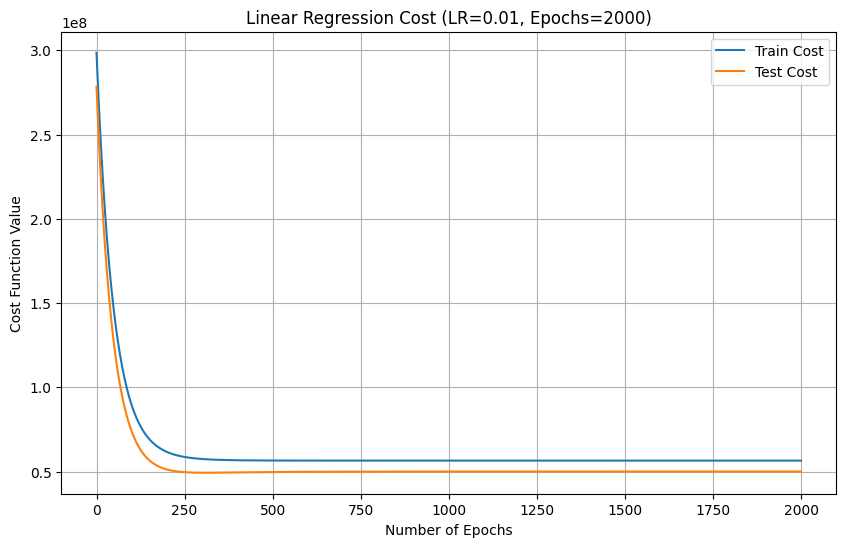

In [4]:
print("\n" + "="*50)
print("PROBLEM 1: LINEAR REGRESSION (Price Estimation)")
print("="*50)

X_train_raw, X_test_raw, Y_train_lin, Y_test_lin = split_data(X_raw, Y_raw)
X_train_lin, X_test_lin = normalize(X_train_raw, X_test_raw)
X_train_bias_lin = add_bias(X_train_lin)
X_test_bias_lin = add_bias(X_test_lin)

learning_rate_lin = 0.01

print(f"Running Gradient Descent (LR={learning_rate_lin}, Epochs={num_epoch})...")
theta_lin, train_costs_lin, test_costs_lin = grad_desc(
    X_train_bias_lin, Y_train_lin, theta_initial.copy(), learning_rate_lin, num_epoch,
    X_test_bias_lin, Y_test_lin, cost_linear, h_linear)

final_test_cost_lin = cost_linear(X_test_bias_lin, Y_test_lin, theta_lin)
print("\n--- RESULTS ---")
print(f"Best Learning Rate: {learning_rate_lin}")
print(f"Best Number of Epochs: {num_epoch}")
print(f"Final Test Cost (MSE): {final_test_cost_lin:,.2f}")

plot_data(train_costs_lin, test_costs_lin, 
          title=f"Linear Regression Cost (LR={learning_rate_lin}, Epochs={num_epoch})",
          filename="linear_regression_cost_plot.png")


PROBLEM 2: LOGISTIC REGRESSION (Binary Price Classification)
Median price used for classification: 14,999.00
Target: 1 (High Price, > Median), 0 (Low Price, <= Median)
Running Gradient Descent (LR=0.1, Epochs=2000)...

--- RESULTS ---
Best Learning Rate: 0.1
Best Number of Epochs: 2000
Final Test Cost (Cross-Entropy): 0.3761


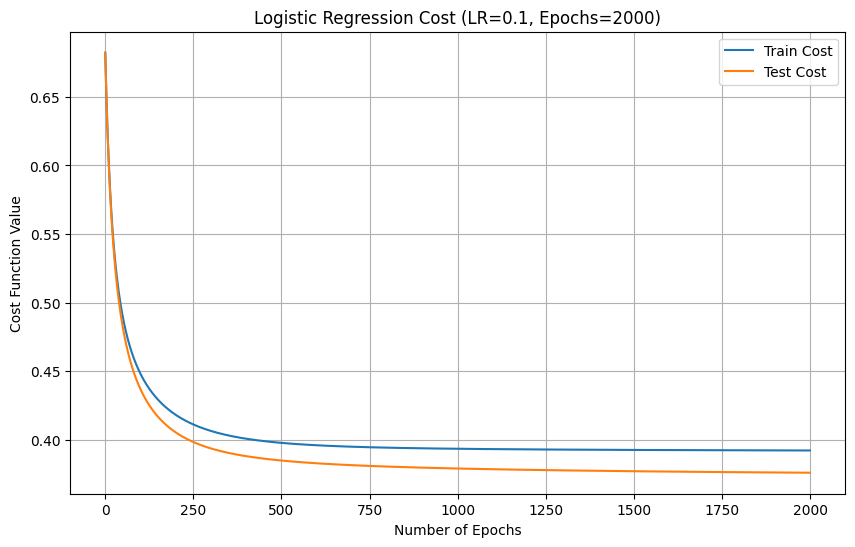

In [5]:
print("\n" + "="*50)
print("PROBLEM 2: LOGISTIC REGRESSION (Binary Price Classification)")
print("="*50)

median_val = np.median(Y_raw)
Y_bin = (Y_raw > median_val).astype(int)
print(f"Median price used for classification: {median_val:,.2f}")
print("Target: 1 (High Price, > Median), 0 (Low Price, <= Median)")

X_train_raw_log, X_test_raw_log, Y_train_log, Y_test_log = split_data(X_raw, Y_bin)
X_train_log, X_test_log = normalize(X_train_raw_log, X_test_raw_log)
X_train_bias_log = add_bias(X_train_log)
X_test_bias_log = add_bias(X_test_log)

learning_rate_log = 0.1

print(f"Running Gradient Descent (LR={learning_rate_log}, Epochs={num_epoch})...")
theta_log, train_costs_log, test_costs_log = grad_desc(
    X_train_bias_log, Y_train_log, theta_initial.copy(), learning_rate_log, num_epoch,
    X_test_bias_log, Y_test_log, cost_logistic, h_logistic)

final_test_cost_log = cost_logistic(X_test_bias_log, Y_test_log, theta_log)
print("\n--- RESULTS ---")
print(f"Best Learning Rate: {learning_rate_log}")
print(f"Best Number of Epochs: {num_epoch}")
print(f"Final Test Cost (Cross-Entropy): {final_test_cost_log:.4f}")

plot_data(train_costs_log, test_costs_log, 
          title=f"Logistic Regression Cost (LR={learning_rate_log}, Epochs={num_epoch})",
          filename="logistic_regression_cost_plot.png")